In [42]:
from functools import partial
from timeit import timeit

import matplotlib.pyplot as plt
import numpy as np
import scipy
from pyedflib import EdfReader

from config.constants import SAMPLING_FREQUENCY_HZ, SPECTRAL_BANDS
from config.paths import PATHS

# Load Data

## Fake Data

In [43]:
# Variables
N_CHANNELS = 2
# n_segs, seg_n_samples = 3, 5
n_segs, seg_n_samples = 3, 3105

n_samples_edf = n_segs * seg_n_samples
segmented_sigs = np.zeros((n_segs, N_CHANNELS, seg_n_samples))

In [44]:
# Generate data
for chn in range(N_CHANNELS):
    sig = np.random.randint(-9, 10, n_samples_edf)
    # sig = np.arange(n_samples_edf)
    # np.random.shuffle(sig, )
    segmented_sigs[:, chn, :] = sig.reshape((n_segs, seg_n_samples))
ss = segmented_sigs  # alias
segmented_sigs

array([[[ 7.,  3.,  0., ...,  6., -2.,  5.],
        [ 5., -2.,  2., ..., -8., -4., -2.]],

       [[-1., -8.,  9., ..., -5., -2.,  5.],
        [-9.,  7.,  2., ...,  4.,  9., -5.]],

       [[-3., -9.,  1., ..., -1., -4., -3.],
        [-3., -1., -1., ...,  1., -6.,  0.]]], shape=(3, 2, 3105))

In [45]:
single_sig = segmented_sigs[0, 0, :]
single_sig

array([ 7.,  3.,  0., ...,  6., -2.,  5.], shape=(3105,))

## Real Data

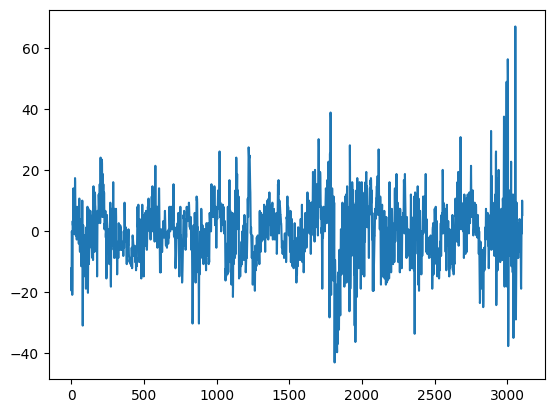

In [46]:
# Read Real Data
ptnt_dir = PATHS.patient_dirs()[0]
edf_path = next(ptnt_dir.edf_dir.iterdir())
with EdfReader(str(edf_path)) as edf:
    single_sig = edf.readSignal(chn=0, start=10000, n=seg_n_samples)
plt.plot(single_sig)
plt.show()

# Compute Feature

In [47]:
# Compute power spectral density (Welch's periodogram)
frequency_resolution = SAMPLING_FREQUENCY_HZ / seg_n_samples
frequency_resolution

0.06667666816689169

In [48]:
# Define window length
lowest_freq_of_interest = 0.5
win_sec = 2 / 0.5
win = win_sec * SAMPLING_FREQUENCY_HZ
print(f"~ {win / 60:.2f} s")
win

~ 13.80 s


828.1242186327949

In [49]:
def plot_periodogram(freqs, psd, idx_band=None, xlim=None, figsize=(12, 4), title="Welch's periodogram",
                     ylabel='Power spectral density ($\mu V^2$ / Hz)'):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(freqs, psd)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_ylim(0, psd.max() * 1.1)
    if idx_band is not None:
        ax.fill_between(freqs, psd, where=idx_band, color='green', alpha=0.5)
    if xlim:
        ax.set_xlim(xlim)
    return fig

In [50]:
freqs, psd = scipy.signal.welch(single_sig,
                                SAMPLING_FREQUENCY_HZ,
                                window='hann',
                                nperseg=win,
                                # scaling='spectrum', # <- todo what about scaling?
                                )
# freqs: frequency bins
# psd: power spectral density for that bin

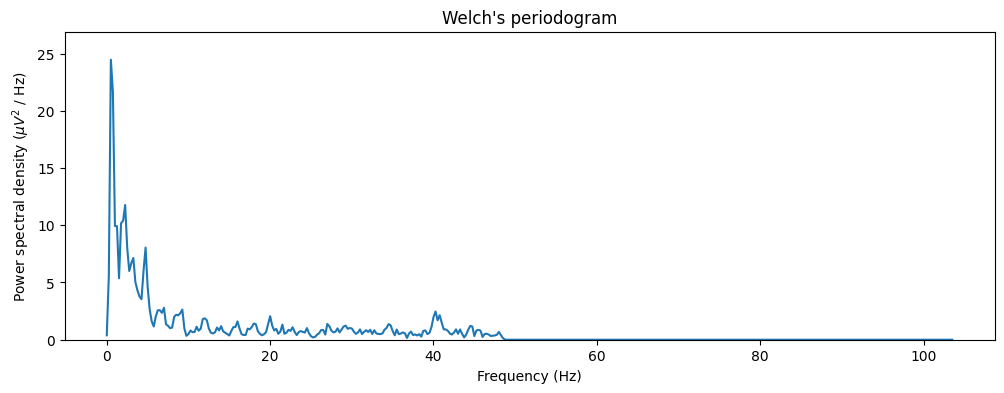

In [51]:
plot_periodogram(freqs, psd).show()

In [52]:
# Defining the delta band
delta = SPECTRAL_BANDS['Delta']
low, high = delta
low, high

(0.5, 4)

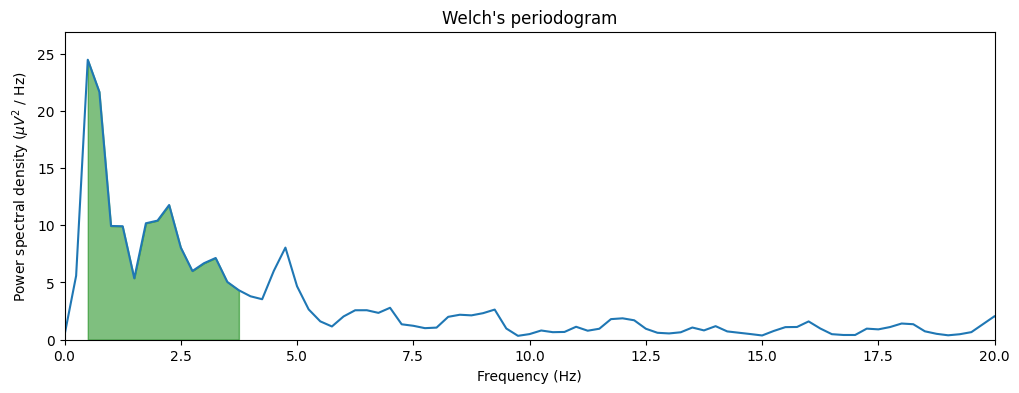

In [53]:
# Find the freqs that belong to delta
idx_delta = (low <= freqs) & (freqs <= high)
plot_periodogram(freqs, psd, idx_delta, [0, 20]).show()

## Absolute Band Power
The blue area is the **absolute band power** of the delta band.
There are various methods to approximate the area (e.g. composite Simpson's rule).

In [54]:
freq_res = freqs[1] - freqs[0]
freq_res

np.float64(0.25003750562584387)

In [55]:
# compute absolute band power by approximating AUC
delta_abs_power = scipy.integrate.simpson(psd[idx_delta], dx=freq_res)
print(f"Absolute delta power: {delta_abs_power:.3f} uV^2")

Absolute delta power: 32.564 uV^2


## Relative Band Power
The band power relative the total power of the signal.

In [56]:
total_power = scipy.integrate.simpson(psd, dx=freq_res)
delta_rel_power = delta_abs_power / total_power
print(f"Relative delta power: {delta_rel_power:.3f}")

Relative delta power: 0.392


# Generalization

In [57]:
def bandpowers(signal, sf, bands, window_sec=None):
    """
    Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    signal : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    bands : dict
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2

    Return
    ------
    bp : float
        Absolute band powers.
    """

    lowest_band_freq = list(bands.values())[0][0]
    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / lowest_band_freq) * sf

    # Compute the periodogram (Welch)
    freqs, psd = scipy.signal.welch(signal, sf,
                                    nperseg=nperseg,
                                    noverlap=nperseg // 2,  # 50% overlap
                                    window='hann',  # tapering
                                    detrend='constant',
                                    )
    freq_res = freqs[1] - freqs[0]

    bandpowers = {}
    for name, (low, high) in bands.items():
        idx_band = (low <= freqs) & (freqs <= high)
        # Integral approximation of the spectrum using Simpson's rule
        bandpowers[name] = scipy.integrate.simpson(psd[idx_band], dx=freq_res)

    return bandpowers

In [58]:
bandpowers(single_sig, SAMPLING_FREQUENCY_HZ, SPECTRAL_BANDS)

{'Delta': np.float64(32.56442133990476),
 'Theta': np.float64(11.19952897835531),
 'Alpha': np.float64(4.917848547960799),
 'Beta': np.float64(18.554860604398073),
 'Gamma': np.float64(9.88875565185109)}

In [59]:
bps_partial = partial(bandpowers, sf=SAMPLING_FREQUENCY_HZ, bands=SPECTRAL_BANDS)
seg_bps = []
for chn in range(N_CHANNELS):
    seg_bps.append([bps_partial(signal=segmented_sigs[seg, chn]) for seg in range(n_segs)])

## Vectorization


In [60]:
# I can compute the welch for the entire file!
freqs, psd = scipy.signal.welch(segmented_sigs, SAMPLING_FREQUENCY_HZ, axis=2)
# ~ 21 sec for 100_00 segs
print(f"{freqs.shape=}")
print(f"{psd.shape=}")

freqs.shape=(129,)
psd.shape=(3, 2, 129)


In [61]:
assert psd.shape[0] == n_segs
assert psd.shape[1] == N_CHANNELS

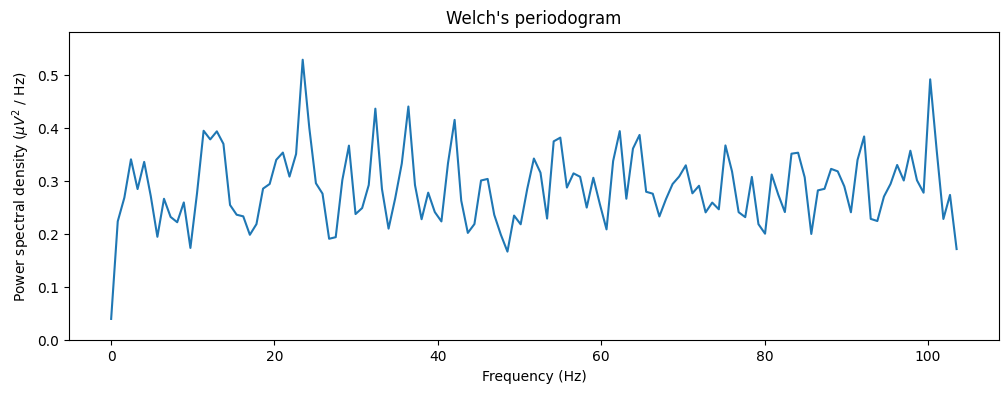

In [63]:
seg, chn = 0, 1
plot_periodogram(freqs, psd[seg, chn]).show()

# FFT Method
It looks much more noisy than Welch's method -> probably not useful

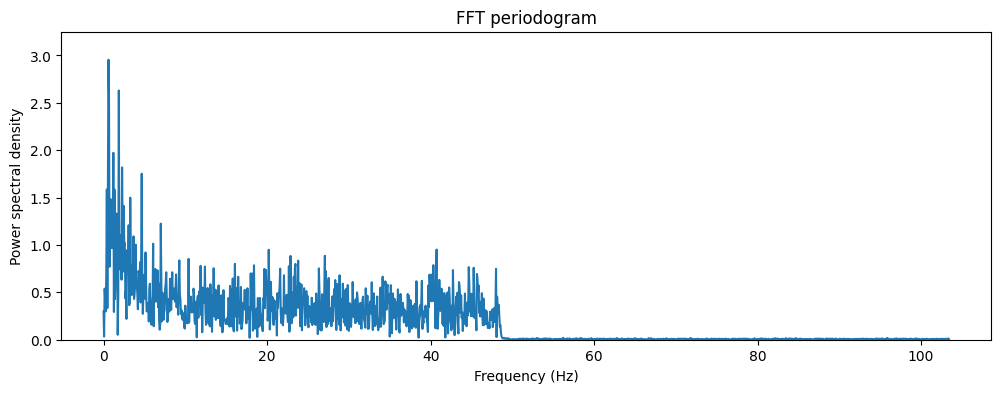

In [40]:
# Number of sample points
N = seg_n_samples
# sample spacing (sampling period)
T = 1.0 / SAMPLING_FREQUENCY_HZ
x = np.linspace(0.0, N * T, N, endpoint=False)
y = single_sig

# comuting the FFT
psd = scipy.fft.fft(y)
freqs = scipy.fft.fftfreq(N, T)[:N // 2]

psd_to_plot = 2.0 / N * np.abs(psd[0:N // 2])
# plt.plot(freqs, psd_to_plot)
# plt.grid()
# plt.show()

plot_periodogram(freqs, psd_to_plot, title='FFT periodogram', ylabel='Power spectral density').show()